In [1]:
#Importing all libraries
import pandas as pd # for loading dataset and data manipulation
import numpy as np # for mathematical operations and array & matrics creation
from sklearn.linear_model import LogisticRegression # for model creation
from sklearn.model_selection import train_test_split, GridSearchCV # for splitting the datasets into training and test dataset and hypertuning
from sklearn.preprocessing import StandardScaler # for standardization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve# for accuracy precision recall, f1 score & roc curve area
import shap

In [2]:
# Load the dataset
file_path = 'C:/Users/vineshine/Desktop/Case Study-Modelv Engg/use_case_1/use_case_1/PSP_Jan_Feb_2019.xlsx'  # Ensure the correct dataset path
data = pd.read_excel(file_path)

In [3]:
data.head()

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   success     50410 non-null  int64         
 5   PSP         50410 non-null  object        
 6   3D_secured  50410 non-null  int64         
 7   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB


In [5]:
data.describe()

,Unnamed: 0,amount,success,3D_secured
count,50410.000000,50410.000000,50410.000000,50410.000000
mean,25204.500000,202.395715,0.202896,0.238266
std,14552.257872,96.274730,0.402160,0.426027
min,0.000000,6.000000,0.000000,0.000000
25%,12602.250000,133.000000,0.000000,0.000000
50%,25204.500000,201.000000,0.000000,0.000000
75%,37806.750000,269.000000,0.000000,0.000000
max,50409.000000,630.000000,1.000000,1.000000


In [6]:
data.isnull().sum()

Unnamed: 0    0
tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

In [7]:
# Data Cleaning - Remove outliers in the 'amount' column using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers in 'amount' column
data_cleaned = remove_outliers_iqr(data, 'amount')

In [8]:
data_cleaned = data_cleaned.copy()
# Convert 'tmsp' to datetime and extract hour and day of the week
data_cleaned['tmsp'] = pd.to_datetime(data_cleaned['tmsp'])
data_cleaned['hour'] = data_cleaned['tmsp'].dt.hour
data_cleaned['day_of_week'] = data_cleaned['tmsp'].dt.dayofweek
data_cleaned['is_weekend'] = data_cleaned['day_of_week'].isin([5, 6]).astype(int)  # Adding a feature for weekends

In [9]:
# Create a retry flag (same amount, country, within one minute)
data_cleaned = data_cleaned.sort_values(by=['country', 'amount', 'tmsp'])  # Sort by country, amount, and timestamp
data_cleaned['prev_country'] = data_cleaned['country'].shift(1)
data_cleaned['prev_amount'] = data_cleaned['amount'].shift(1)
data_cleaned['prev_tmsp'] = data_cleaned['tmsp'].shift(1)
data_cleaned['time_diff'] = (data_cleaned['tmsp'] - data_cleaned['prev_tmsp']).dt.total_seconds()

# Create the retry_flag: 1 if same country, amount, and within 60 seconds
data_cleaned['retry_flag'] = ((data_cleaned['country'] == data_cleaned['prev_country']) &
                              (data_cleaned['amount'] == data_cleaned['prev_amount']) &
                              (data_cleaned['time_diff'] <= 60)).astype(int)

# Drop intermediate columns
data_cleaned.drop(columns=['prev_country', 'prev_amount', 'prev_tmsp', 'time_diff'], inplace=True)

In [10]:
# Define the fees based on the PSP and success/failure
fees = {
    'Moneycard': {1: 5, 0: 2},
    'Goldcard': {1: 10, 0: 5},
    'UK_Card': {1: 3, 0: 1},
    'Simplecard': {1: 1, 0: 0.5}
}
# Create a new column for PSP fees based on success/failure
data_cleaned['psp_fee'] = data_cleaned.apply(lambda x: fees[x['PSP']][x['success']], axis=1)

In [11]:
# One-hot encode categorical variables
data_encoded = pd.get_dummies(data_cleaned, columns=['country', 'PSP', 'card'])

In [12]:
# Drop unused columns and prepare features and target variable
X = data_encoded.drop(columns=['tmsp', 'success', 'psp_fee','Unnamed: 0'])
y = data_encoded['success']
psp_fees = data_encoded['psp_fee']

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, fees_train, fees_test = train_test_split(X, y, psp_fees, test_size=0.2, random_state=42)

In [14]:
# Standardizing relevant features
scaler = StandardScaler()
X_train[['amount', 'hour', 'day_of_week', 'is_weekend']] = scaler.fit_transform(X_train[['amount', 'hour', 'day_of_week', 'is_weekend']])
X_test[['amount', 'hour', 'day_of_week', 'is_weekend']] = scaler.transform(X_test[['amount', 'hour', 'day_of_week', 'is_weekend']])

In [15]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs']  # Stable solvers only
}

In [16]:
grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=5000), 
                           param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000, random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

In [17]:
# Best model from grid search
best_model = grid_search.best_estimator_

In [18]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

In [19]:
# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(f"Confusion Matrix:\n{cm}")

Best Hyperparameters: {'C': 10, 'solver': 'liblinear'}
Accuracy: 0.79
Precision: 0.59
Recall: 0.01
F1 Score: 0.03
ROC-AUC Score: 0.62
Confusion Matrix:
[[7932   21]
 [2069   30]]


In [21]:
# Calculate the expected transaction fees
expected_fees = (1 - y_pred_prob) * fees_test + y_pred_prob * fees_test
total_expected_fees = expected_fees.sum()

print(f'Total Expected Transaction Fees (including failed transactions): {total_expected_fees:.2f}')

Total Expected Transaction Fees (including failed transactions): 17744.00


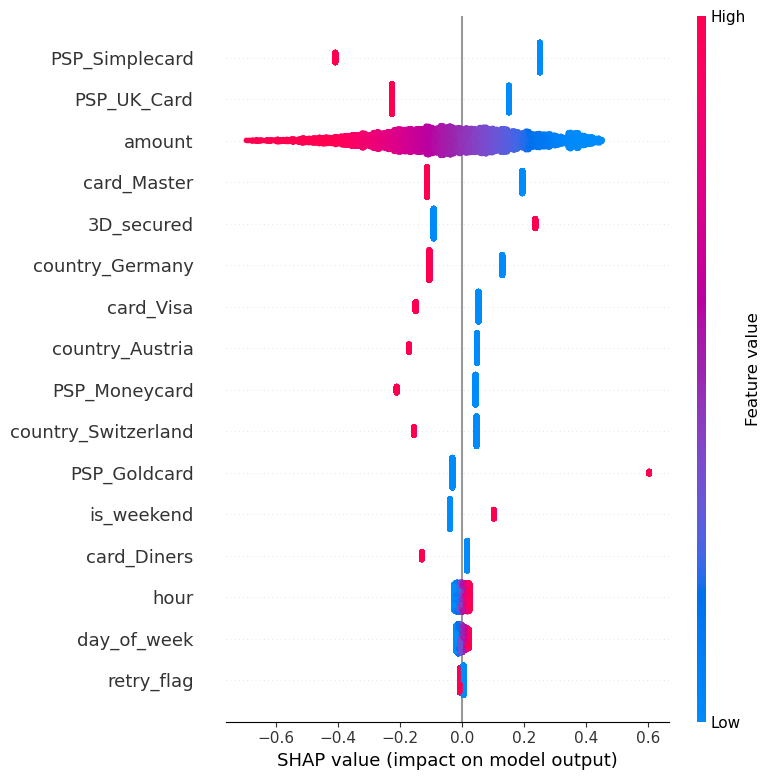

In [22]:
# SHAP for interpretability
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# Plot SHAP values for the first prediction
shap.initjs()
shap.summary_plot(shap_values, X_test)

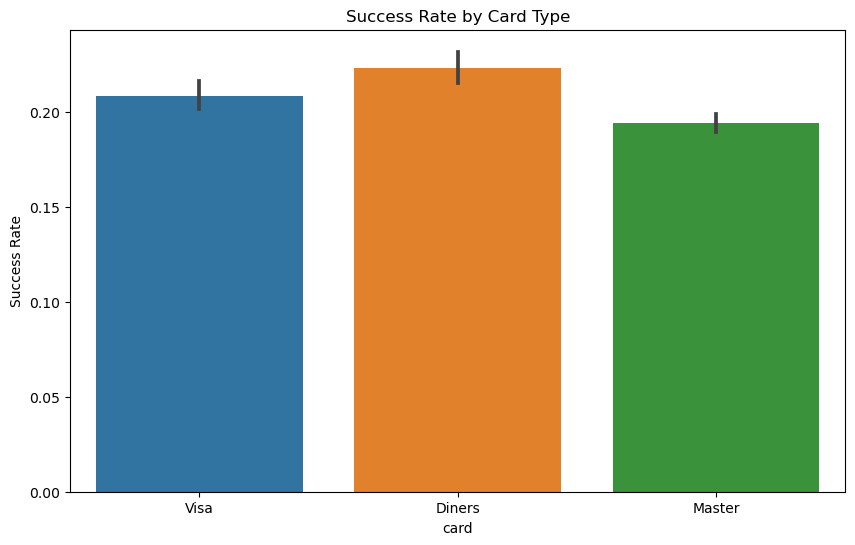

In [23]:
# importing libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Plot: Success Rate by Card Type
plt.figure(figsize=(10, 6))
sns.barplot(x='card', y='success', data=data, estimator=lambda x: sum(x) / len(x))
plt.title('Success Rate by Card Type')
plt.ylabel('Success Rate')
plt.show()

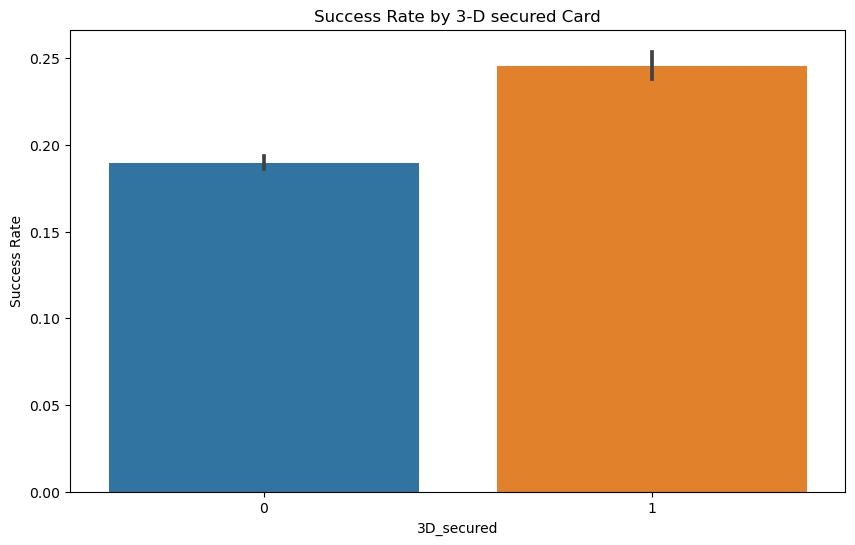

In [24]:
# Plot: Success Rate by Card Type
plt.figure(figsize=(10, 6))
sns.barplot(x='3D_secured', y='success', data=data, estimator=lambda x: sum(x) / len(x))
plt.title('Success Rate by 3-D secured Card')
plt.ylabel('Success Rate')
plt.show()

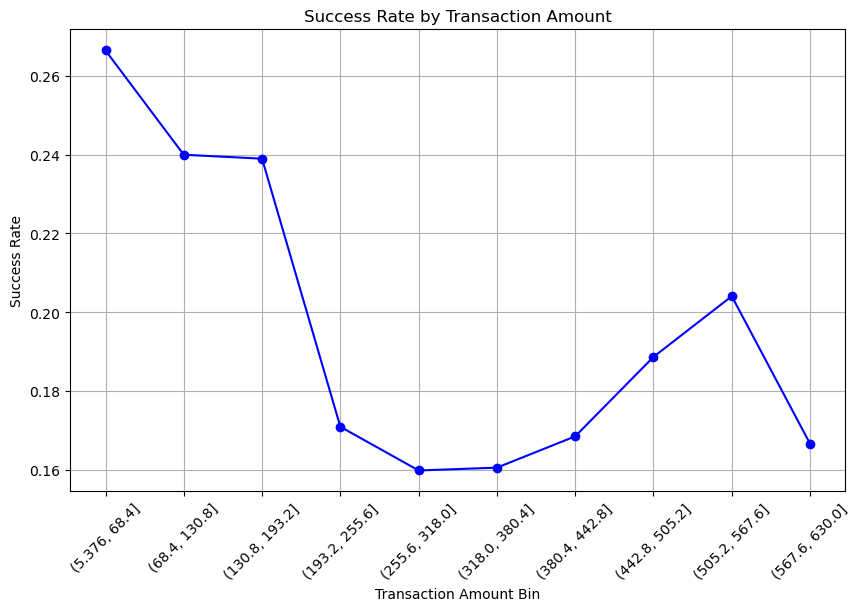

In [25]:
# Create bins for the transaction amounts (e.g., 10 bins)
data['amount_bin'] = pd.cut(data['amount'], bins=10)

# Group the data by amount_bin and calculate the success rate for each bin
success_rate_by_amount = data.groupby('amount_bin')['success'].mean()

# Plot the success rate by amount bin (line chart)
plt.figure(figsize=(10, 6))
plt.plot(success_rate_by_amount.index.astype(str), success_rate_by_amount, marker='o', linestyle='-', color='b')
plt.title('Success Rate by Transaction Amount')
plt.xlabel('Transaction Amount Bin')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

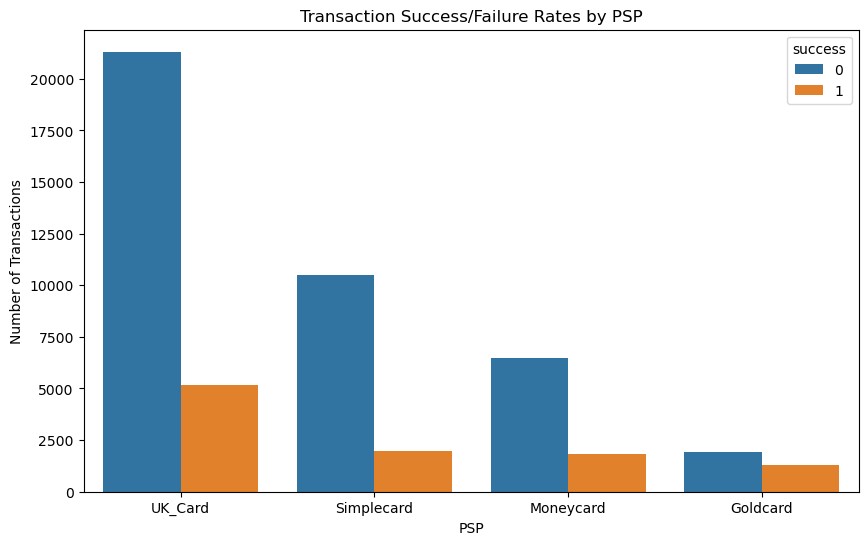

In [26]:
# Countplot to show the number of transactions per PSP
plt.figure(figsize=(10, 6))
sns.countplot(x='PSP', data=data, hue='success')
plt.title('Transaction Success/Failure Rates by PSP')
plt.ylabel('Number of Transactions')
plt.show()

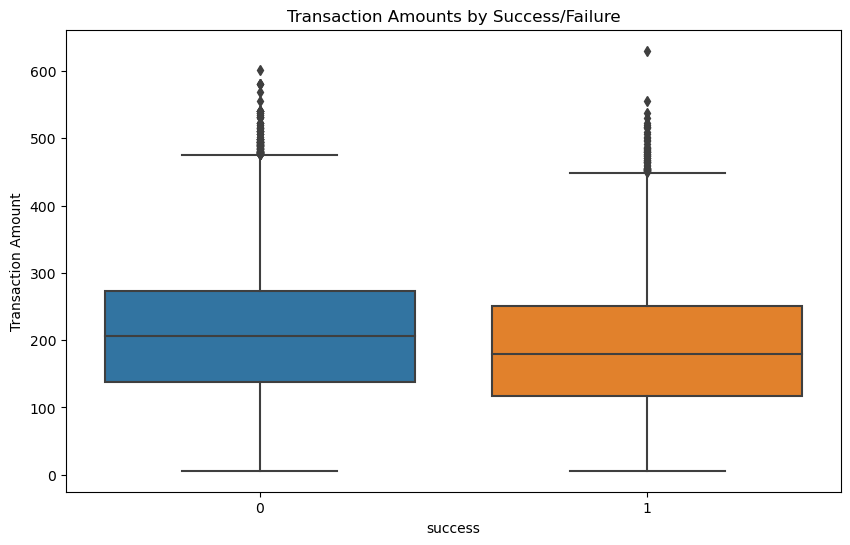

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='success', y='amount', data=data)
plt.title('Transaction Amounts by Success/Failure')
plt.ylabel('Transaction Amount')
plt.show()

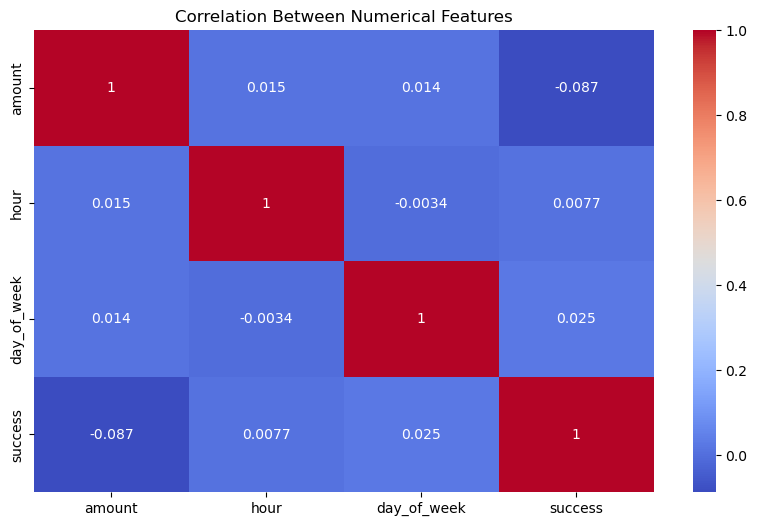

In [28]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data_cleaned[['amount', 'hour', 'day_of_week', 'success']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Numerical Features')
plt.show()

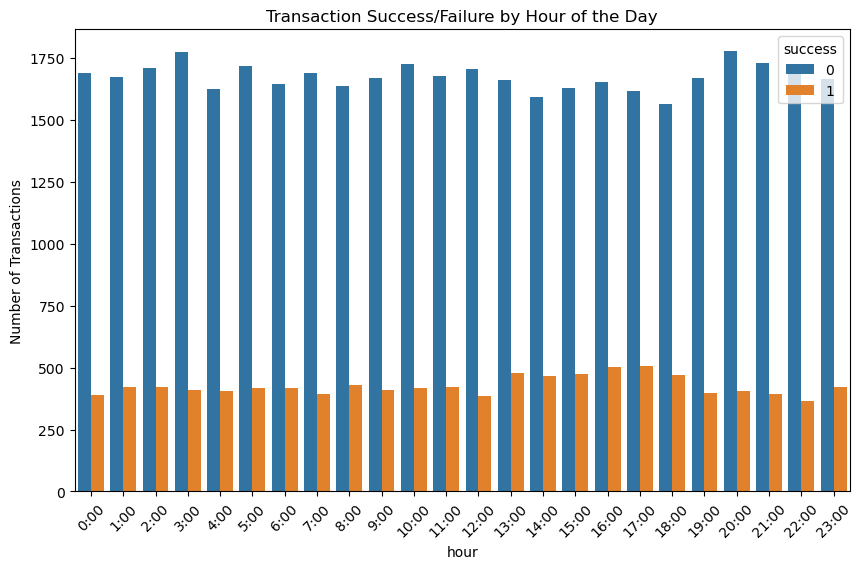

In [29]:
# Ensure that the 'tmsp' column is in datetime format
data['tmsp'] = pd.to_datetime(data['tmsp'])

# Extract the hour from the 'tmsp' column
data['hour'] = data['tmsp'].dt.hour


# Set up the figure size
plt.figure(figsize=(10, 6))

# Create the countplot with 'hour' on the x-axis and 'success' as the hue
sns.countplot(x='hour', hue='success', data=data)

# Add title and labels
plt.title('Transaction Success/Failure by Hour of the Day')
plt.ylabel('Number of Transactions')

# Customize x-axis tick labels to show hours in the correct format (0 to 23)
plt.xticks(ticks=range(24), labels=[str(i) + ':00' for i in range(24)], rotation=45)

# Show the plot
plt.show()


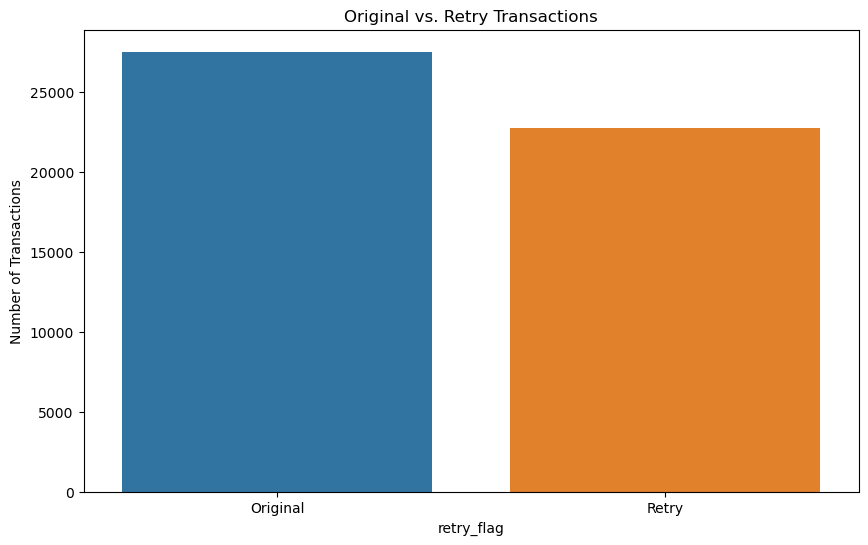

In [30]:
plt.figure(figsize=(10, 6))
sns.countplot(x='retry_flag', data=data_cleaned)
plt.title('Original vs. Retry Transactions')
plt.xticks([0, 1], ['Original', 'Retry'])
plt.ylabel('Number of Transactions')
plt.show()

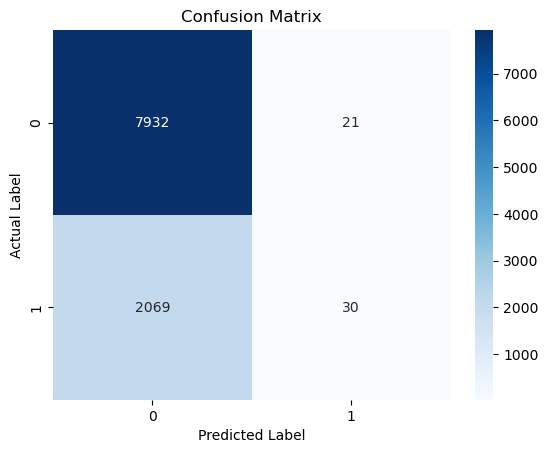

In [31]:
from sklearn.metrics import confusion_matrix
# Assuming you have y_test (actual) and y_pred (predicted) from your model
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

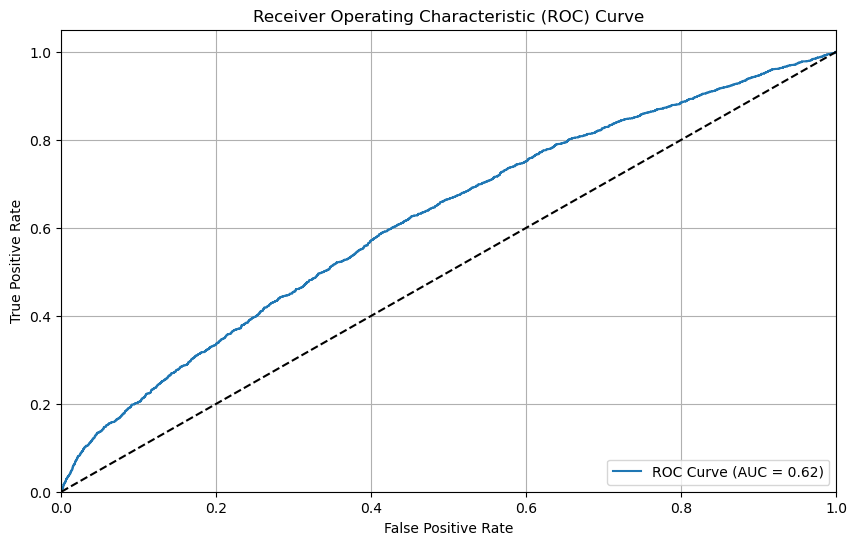

In [32]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()